# Historical Stock Price Collection and Analysis

## Overview:
In this notebook, we will collect and analyze historical stock price data using `yfinance` and other Python libraries. We will calculate log returns, visualize the OHLC (Open, High, Low, Close) charts, and save the processed data to CSV files for future analysis. The notebook supports processing data for multiple stock tickers and includes a function to automate this workflow.

## Steps:
1. **Data Fetching**: We will use the `yfinance` library to fetch historical stock price data for specified tickers and a given date range.
2. **Log Returns Calculation**: Logarithmic returns between consecutive closing prices will be computed to understand the rate of return on the stock.
3. **Data Export**: The stock price data, along with the log returns, will be saved to a CSV file for further analysis.
4. **OHLC Chart Visualization**: We will generate time-series visualizations of the OHLC data, with volume plotted as bars in the background, to give a clear view of stock price movements.
5. **Batch Processing**: The notebook supports processing multiple stock tickers in one run, saving each ticker's data and visualizations independently.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from statsmodels.tsa.stattools import adfuller


In [ ]:
def fetch_stock_data(ticker, start_date, end_date): 
    """ 
    Fetch historical stock price data using yfinance.
    Parameters:
        ticker (str): Stock ticker symbol.
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.

    Returns:
    pd.DataFrame: Stock price data.
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    # Replace spaces in column names with underscores
    stock_data.columns = stock_data.columns.str.replace(' ', '_')
    
    return stock_data

In [ ]:
def calculate_log_returns(data):
    """
    Calculate log returns for different price points from stock price data.
    
    Parameters:
    data (pd.DataFrame): Stock price data with 'Open', 'High', 'Low', 'Close', and 'Adj Close' prices.
    
    Returns:
    pd.DataFrame: DataFrame with added columns for various log returns.
    """
    # Close to Close (Consecutive Days)
    data['Log_Return_Close_Close'] = np.log(data['Adj_Close'] / data['Adj_Close'].shift(1))

    # Open to Close (Same Day)
    data['Log_Return_Open_Close'] = np.log(data['Close'] / data['Open'])

    # High to Low (Same Day)
    data['Log_Return_High_Low'] = np.log(data['High'] / data['Low'])

    # Open to Open (Consecutive Days)
    data['Log_Return_Open_Open'] = np.log(data['Open'] / data['Open'].shift(1))

    # Close to Open (Next Day Open)
    data['Log_Return_Close_Open'] = np.log(data['Open'] / data['Close'].shift(1))

    # Drop NaN rows generated by the shift operation
    return data.dropna()



In [ ]:
def calculate_differencing(data, column):
    """
    Apply differencing to make the time series data stationary.
    
    Parameters:
    data (pd.DataFrame): The time series data with stock prices or other time series values.
    column (str): The column name of the time series to be differenced.
    
    Returns:
    pd.DataFrame: DataFrame with added column for differenced time series.
    """
    # Differencing Method
    data[f'Differenced_{column}'] = data[column] - data[column].shift(1)

    # Drop NaN rows generated by the shift operation
    return data.dropna()


In [ ]:
def save_to_csv(data, ticker, folder='data'):
    """
    Save the stock data to a CSV file.
    
    Parameters:
    data (pd.DataFrame): Stock price data with log returns.
    ticker (str): Stock ticker symbol.
    folder (str): Folder path to save the CSV.
    
    Returns:
    None
    """
    filename = f"../{folder}/processed/{ticker}.csv"
    data.to_csv(filename)
    print(f"Data saved to {filename}")


In [ ]:
def plot_ohlc_chart_with_volume(data, ticker):
    """
    Plot OHLC time series chart with volume bars in the background using mplfinance.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing 'Open', 'High', 'Low', 'Close', and 'Volume' prices and date index.
    ticker (str): The stock ticker symbol.
    
    Returns:
    None
    """
    data.index = pd.to_datetime(data.index)

    # Plot OHLC chart using mplfinance with volume bars
    mpf.plot(
        data,
        type='ohlc',
        style='yahoo',
        title=f'OHLC Time Series for {ticker}',
        ylabel='Price',
        volume=True,
        ylabel_lower='Volume',
        figratio=(10, 7),
        figscale=1.2,
        show_nontrading=False
    )
    plt.show()


In [ ]:
def plot_differenced_adj_close(data, ticker):
    """
    Plot the Differenced 'Adj Close' time series to check for stationarity.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing 'Differenced_Adj_Close' and date index.
    ticker (str): The stock ticker symbol.
    
    Returns:
    None
    """
    # Ensure the index is a datetime type
    data.index = pd.to_datetime(data.index)

    # Plot the Differenced Adj Close
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Differenced_Adj_Close'], label='Differenced Adj Close', color='blue')

    # Chart details
    plt.title(f'Differenced Adj Close for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Differenced Adj Close')
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()

In [ ]:
def run_adf_test(data, column):
    """
    Run the Augmented Dickey-Fuller (ADF) test to check for stationarity.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the time series data.
    column (str): The column name of the time series to be tested.
    
    Returns:
    None: Prints the ADF test results.
    """
    # Extract the column as a pandas Series
    timeseries = data[column].dropna()

    # Run ADF test
    result = adfuller(timeseries)

    # Print the test statistic and p-value
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

    # Print critical values
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')

    # Interpret the p-value
    if result[1] < 0.05:
        print("\nThe time series is stationary.")
    else:
        print("\nThe time series is not stationary.")

In [ ]:
def run_workflow(ticker, start_date, end_date):
    """
    Main workflow function to fetch data, calculate log returns, save to CSV, and plot OHLC chart.
    
    Parameters:
    ticker (str): Stock ticker symbol.
    start_date (str): Start date in the format 'YYYY-MM-DD'.
    end_date (str): End date in the format 'YYYY-MM-DD'.
    
    Returns:
    None
    """
    # Fetch stock data
    stock_data = fetch_stock_data(ticker, start_date, end_date)

    # Calculate log returns
    stock_data = calculate_log_returns(stock_data)
    
    #Caluclaute percentage simple returns
    stock_data = calculate_differencing(stock_data, 'Adj_Close')

    run_adf_test(stock_data,'Differenced_Adj_Close')
    
    # Save data to CSV
    save_to_csv(stock_data, ticker)

    # Plot OHLC chart
    plot_ohlc_chart_with_volume(stock_data, ticker)
    plot_differenced_adj_close(stock_data, ticker)



[*********************100%***********************]  1 of 1 completed
C:\Users\erikp\AppData\Local\Temp\ipykernel_31264\911960552.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Differenced_{column}'] = data[column] - data[column].shift(1)
C:\CoDE\Scoop\apps\python\current\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ===========================

ADF Statistic: -12.711543413098694
p-value: 1.0275821829836477e-23
Critical Value (1%): -3.432135020388135
Critical Value (5%): -2.862328722835932
Critical Value (10%): -2.5671898489444147

The time series is stationary.
Data saved to ../data/processed/SPY.csv


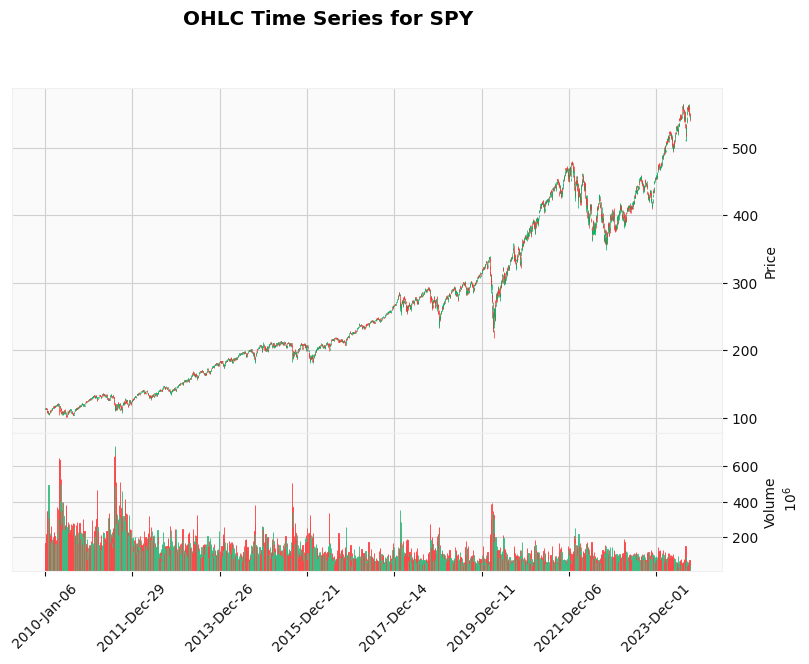

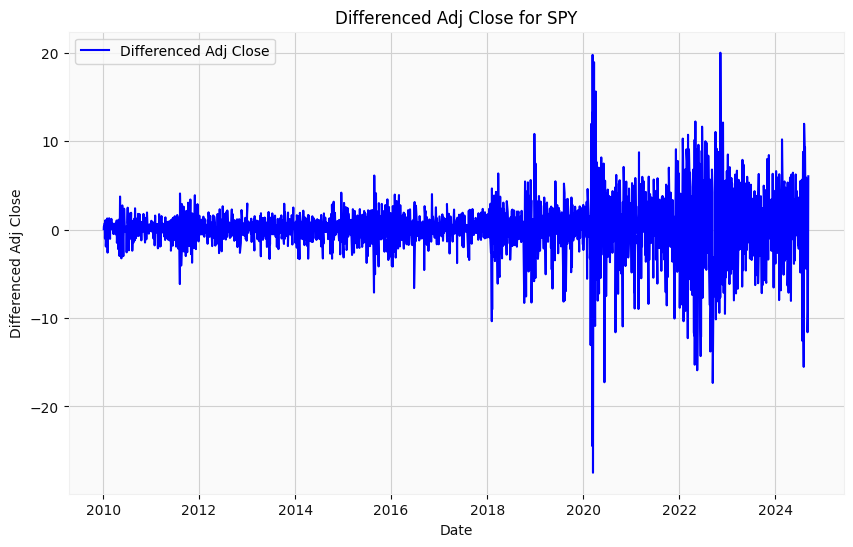

In [97]:
# Example usage
ticker = 'SPY'
start_date = '2010-01-01'
end_date = '2024-09-10'

run_workflow(ticker, start_date, end_date)
